# COVID-19 대한민국 해외 유입 확진자 예측 모델 : LSTM

In [965]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


# 1. Load Dataset

In [966]:
df = pd.read_csv('./data/final_0505.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [967]:
for i in list(df.columns):
    if i[0:2] == 'KR':
        print(i)

KR


In [968]:
df.head()

,Date,BO_conf,BN_conf,MM_conf,CF_conf,CD_conf,CI_conf,DO_conf,GM_conf,IR_conf,...,UG_roam,US_roam,UY_roam,UZ_roam,VN_roam,YE_roam,ZA_roam,ZM_roam,ZW_roam,target
0,2020-01-22,0,0,0,0,0,0,0,0,0,...,0,701,5,127,2592,0,12,0,0,0.0
1,2020-01-23,0,0,0,0,0,0,0,0,0,...,12,943,22,63,2338,0,21,9,3,0.0
2,2020-01-24,0,0,0,0,0,0,0,0,0,...,15,864,14,42,2251,0,0,0,0,1.0
3,2020-01-25,0,0,0,0,0,0,0,0,0,...,6,828,22,82,2336,0,12,0,0,0.0
4,2020-01-26,0,0,0,0,0,0,0,0,0,...,0,900,7,45,2695,0,6,0,0,1.0


In [969]:
df.Date = pd.to_datetime(df.Date)

In [970]:
df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('Date', inplace=True)

In [557]:
df.tail()

,BO_conf,BN_conf,MM_conf,CF_conf,CD_conf,CI_conf,DO_conf,GM_conf,IR_conf,LA_conf,...,US_roam,UY_roam,UZ_roam,VN_roam,YE_roam,ZA_roam,ZM_roam,ZW_roam,target,dayofweek
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,119,0,0,22,32,58,316,1,1006,0,...,52,3,0,43,0,3,0,0,8.0,4
2020-05-02,0,0,0,0,70,29,290,5,802,0,...,108,6,6,15,0,3,0,0,8.0,5
2020-05-03,365,0,4,0,0,36,376,0,976,0,...,116,5,0,48,0,0,0,0,10.0,6
2020-05-04,87,0,6,13,8,34,281,0,1223,0,...,72,4,0,91,0,3,0,0,8.0,0
2020-05-05,121,0,0,0,23,32,245,0,1323,0,...,119,6,0,40,0,6,0,0,3.0,1


In [309]:
df.rename(columns={'TARGET':'oversea_inflow'}, inplace=True)

In [ ]:
df['target'] = df['oversea_inflow'].diff()

In [311]:
cols = ['EURO_conf',
 'CHINA_conf',
 'ASIA_conf',
 'AMERICA_conf',]

In [312]:
cols

['EURO_conf', 'CHINA_conf', 'ASIA_conf', 'AMERICA_conf']

In [180]:
t_cols = []
for col in cols:
    tmp = '{}_1'.format(col)
    t_cols.append(tmp)
    df[tmp] = df['{}'.format(col)].diff()

In [241]:
df.isnull().sum()

BO_conf      0
BN_conf      0
MM_conf      0
CF_conf      0
CD_conf      0
            ..
ZA_roam      0
ZM_roam      0
ZW_roam      0
target       0
dayofweek    0
Length: 308, dtype: int64

In [182]:
t_cols

['EURO_conf_1', 'CHINA_conf_1', 'ASIA_conf_1', 'AMERICA_conf_1']

In [183]:
df.head()

,EURO_conf,CHINA_conf,ASIA_conf,AMERICA_conf,EURO_roam,CHINA_roam,ASIA_roam,AMERICA_roam,oversea_inflow,NEWS,dayofweek,target,EURO_conf_1,CHINA_conf_1,ASIA_conf_1,AMERICA_conf_1
Date,,,,,,,,,,,,,,,,
2020-01-22,0,548,5,1,1955.0,3014.0,8946.0,701.0,1,430,2,NaN,NaN,NaN,NaN,NaN
2020-01-23,0,643,9,1,1913.0,2677.0,7924.0,943.0,1,452,3,0.0,0.0,95.0,4.0,0.0
2020-01-24,2,920,15,2,2286.0,2197.0,7356.0,864.0,2,421,4,1.0,2.0,277.0,6.0,1.0
2020-01-25,3,1406,17,2,1472.0,1825.0,7518.0,828.0,2,506,5,0.0,1.0,486.0,2.0,0.0
2020-01-26,3,2075,22,5,1932.0,3252.0,11149.0,900.0,3,552,6,1.0,0.0,669.0,5.0,3.0


In [184]:
df.loc['2020-01-22',t_cols] = 0
df.target.iloc[0] = 0

In [185]:
# 일일 해외유입 확진자를 구할때 첫번째 로우는 NaN이기 때문에 0값을 넣어준다.
df['target'][0] = 0

In [830]:
#df = df.iloc[39:]

In [837]:
df.tail()

,BO_conf,BN_conf,MM_conf,CF_conf,CD_conf,CI_conf,DO_conf,GM_conf,IR_conf,LA_conf,...,US_roam,UY_roam,UZ_roam,VN_roam,YE_roam,ZA_roam,ZM_roam,ZW_roam,target,dayofweek
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,119,0,0,22,32,58,316,1,1006,0,...,52,3,0,43,0,3,0,0,8.0,4
2020-05-02,0,0,0,0,70,29,290,5,802,0,...,108,6,6,15,0,3,0,0,8.0,5
2020-05-03,365,0,4,0,0,36,376,0,976,0,...,116,5,0,48,0,0,0,0,10.0,6
2020-05-04,87,0,6,13,8,34,281,0,1223,0,...,72,4,0,91,0,3,0,0,8.0,0
2020-05-05,121,0,0,0,23,32,245,0,1323,0,...,119,6,0,40,0,6,0,0,3.0,1


## lag 변수 생성

In [971]:
lag_amount = 7

for i in range(lag_amount):
    df['lag{}'.format(i+1)] = df['target'].shift(i+1)
    
df.dropna(inplace=True)

In [972]:
df.head()

,BO_conf,BN_conf,MM_conf,CF_conf,CD_conf,CI_conf,DO_conf,GM_conf,IR_conf,LA_conf,...,ZW_roam,target,dayofweek,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-29,0,0,0,0,0,0,0,0,0,0,...,9,0.0,2,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2020-01-30,0,0,0,0,0,0,0,0,0,0,...,9,2.0,3,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2020-01-31,0,0,0,0,0,0,0,0,0,0,...,9,1.0,4,2.0,0.0,0.0,1.0,1.0,0.0,1.0
2020-02-01,0,0,0,0,0,0,0,0,0,0,...,3,1.0,5,1.0,2.0,0.0,0.0,1.0,1.0,0.0
2020-02-02,0,0,0,0,0,0,0,0,0,0,...,0,2.0,6,1.0,1.0,2.0,0.0,0.0,1.0,1.0


In [973]:
df.tail()

,BO_conf,BN_conf,MM_conf,CF_conf,CD_conf,CI_conf,DO_conf,GM_conf,IR_conf,LA_conf,...,ZW_roam,target,dayofweek,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,119,0,0,22,32,58,316,1,1006,0,...,0,8.0,4,4.0,5.0,12.0,7.0,10.0,4.0,2.0
2020-05-02,0,0,0,0,70,29,290,5,802,0,...,0,8.0,5,8.0,4.0,5.0,12.0,7.0,10.0,4.0
2020-05-03,365,0,4,0,0,36,376,0,976,0,...,0,10.0,6,8.0,8.0,4.0,5.0,12.0,7.0,10.0
2020-05-04,87,0,6,13,8,34,281,0,1223,0,...,0,8.0,0,10.0,8.0,8.0,4.0,5.0,12.0,7.0
2020-05-05,121,0,0,0,23,32,245,0,1323,0,...,0,3.0,1,8.0,10.0,8.0,8.0,4.0,5.0,12.0


# Data Exploration

In [974]:
# 결측치 확인
df.isnull().sum().sum()

0

In [975]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['target'].shape))

전체 데이터 shape: (98, 316)
target feature shape: (98,)


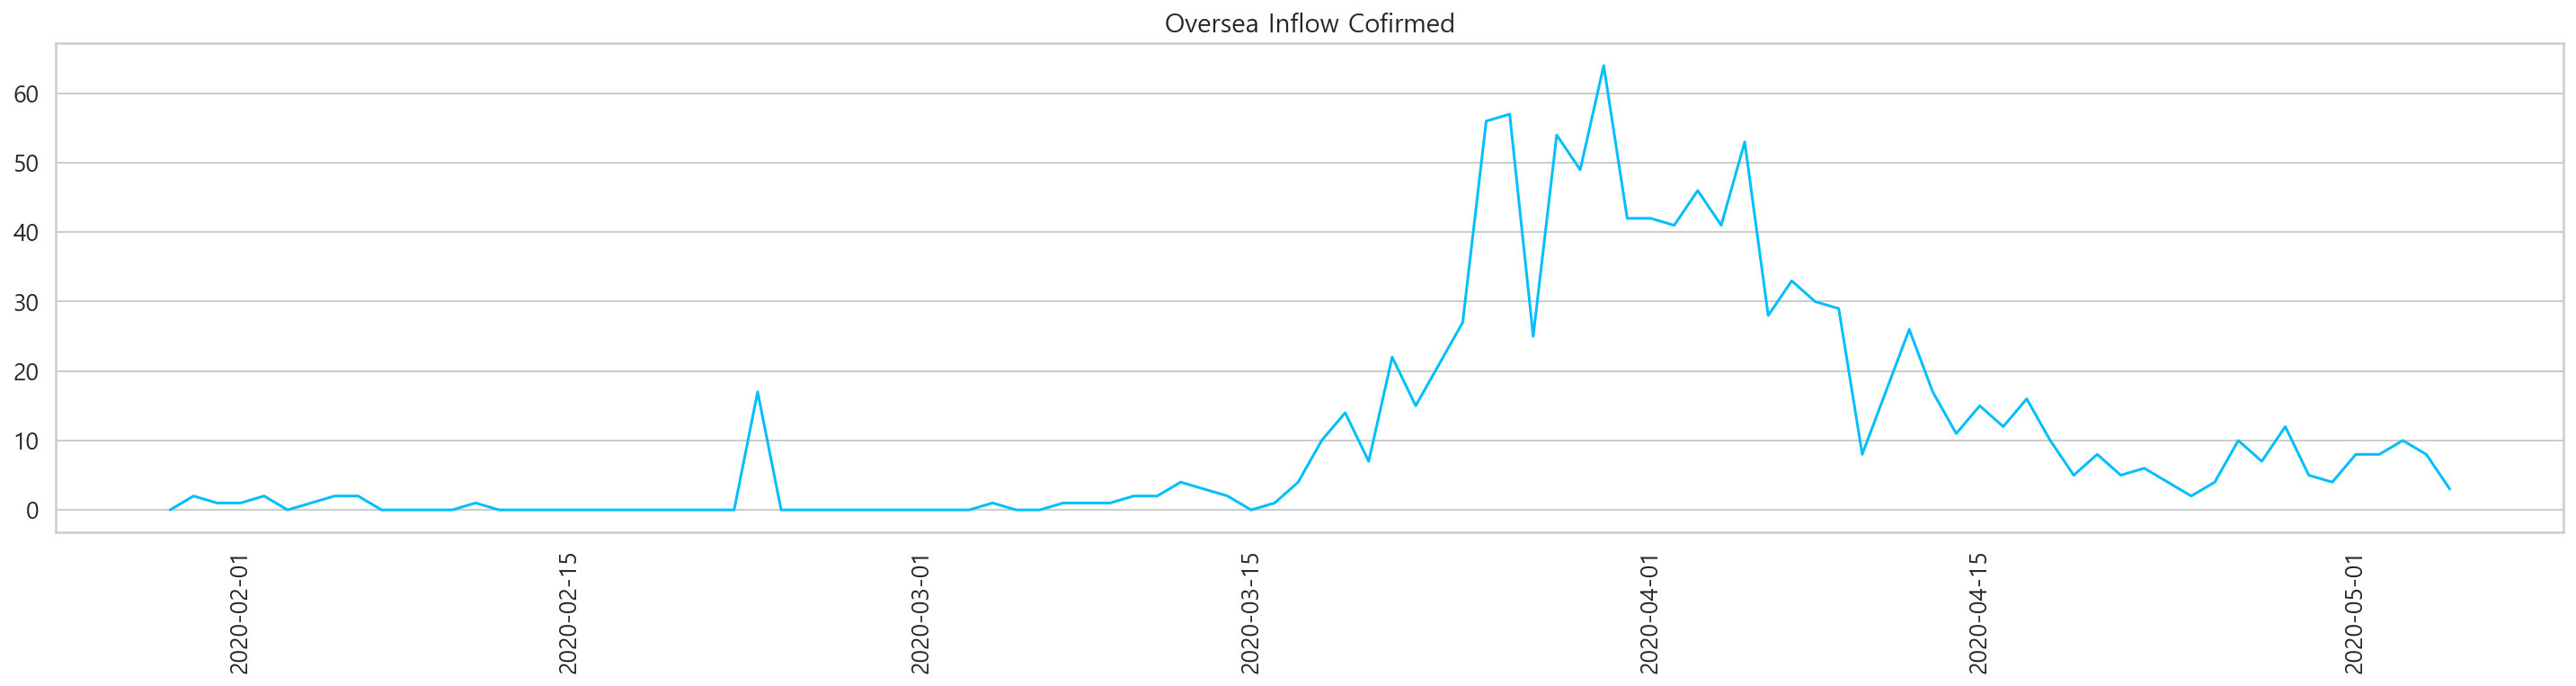

In [976]:
plt.figure(figsize=(25,5))
plt.plot(df['target'])
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')

# Preprocessing

## Feature Selection

In [903]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [977]:
# 테스트 데이터 수
test_data_size = 28

# X변수들과 y변수 구분
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [978]:
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [912]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
}

In [913]:
# grid search
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [914]:
CV_rfc

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [915]:
CV_rfc.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [916]:
CV_rfc.best_params_

{'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}

In [979]:
# parameter 설정후에 다시 진행
rf = RandomForestRegressor(n_estimators=200, max_depth=4, max_features='auto')
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [980]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = list(X.columns)
df_importance['Importance'] = rf.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
314,lag6,0.408
12,NE_conf,0.102
54,CY_conf,0.078
312,lag4,0.076
81,IL_conf,0.054
...,...,...
278,RW_roam,0.000
205,GE_roam,0.000
280,SC_roam,0.000
194,DZ_roam,0.000


Text(0, 0.5, '변수')

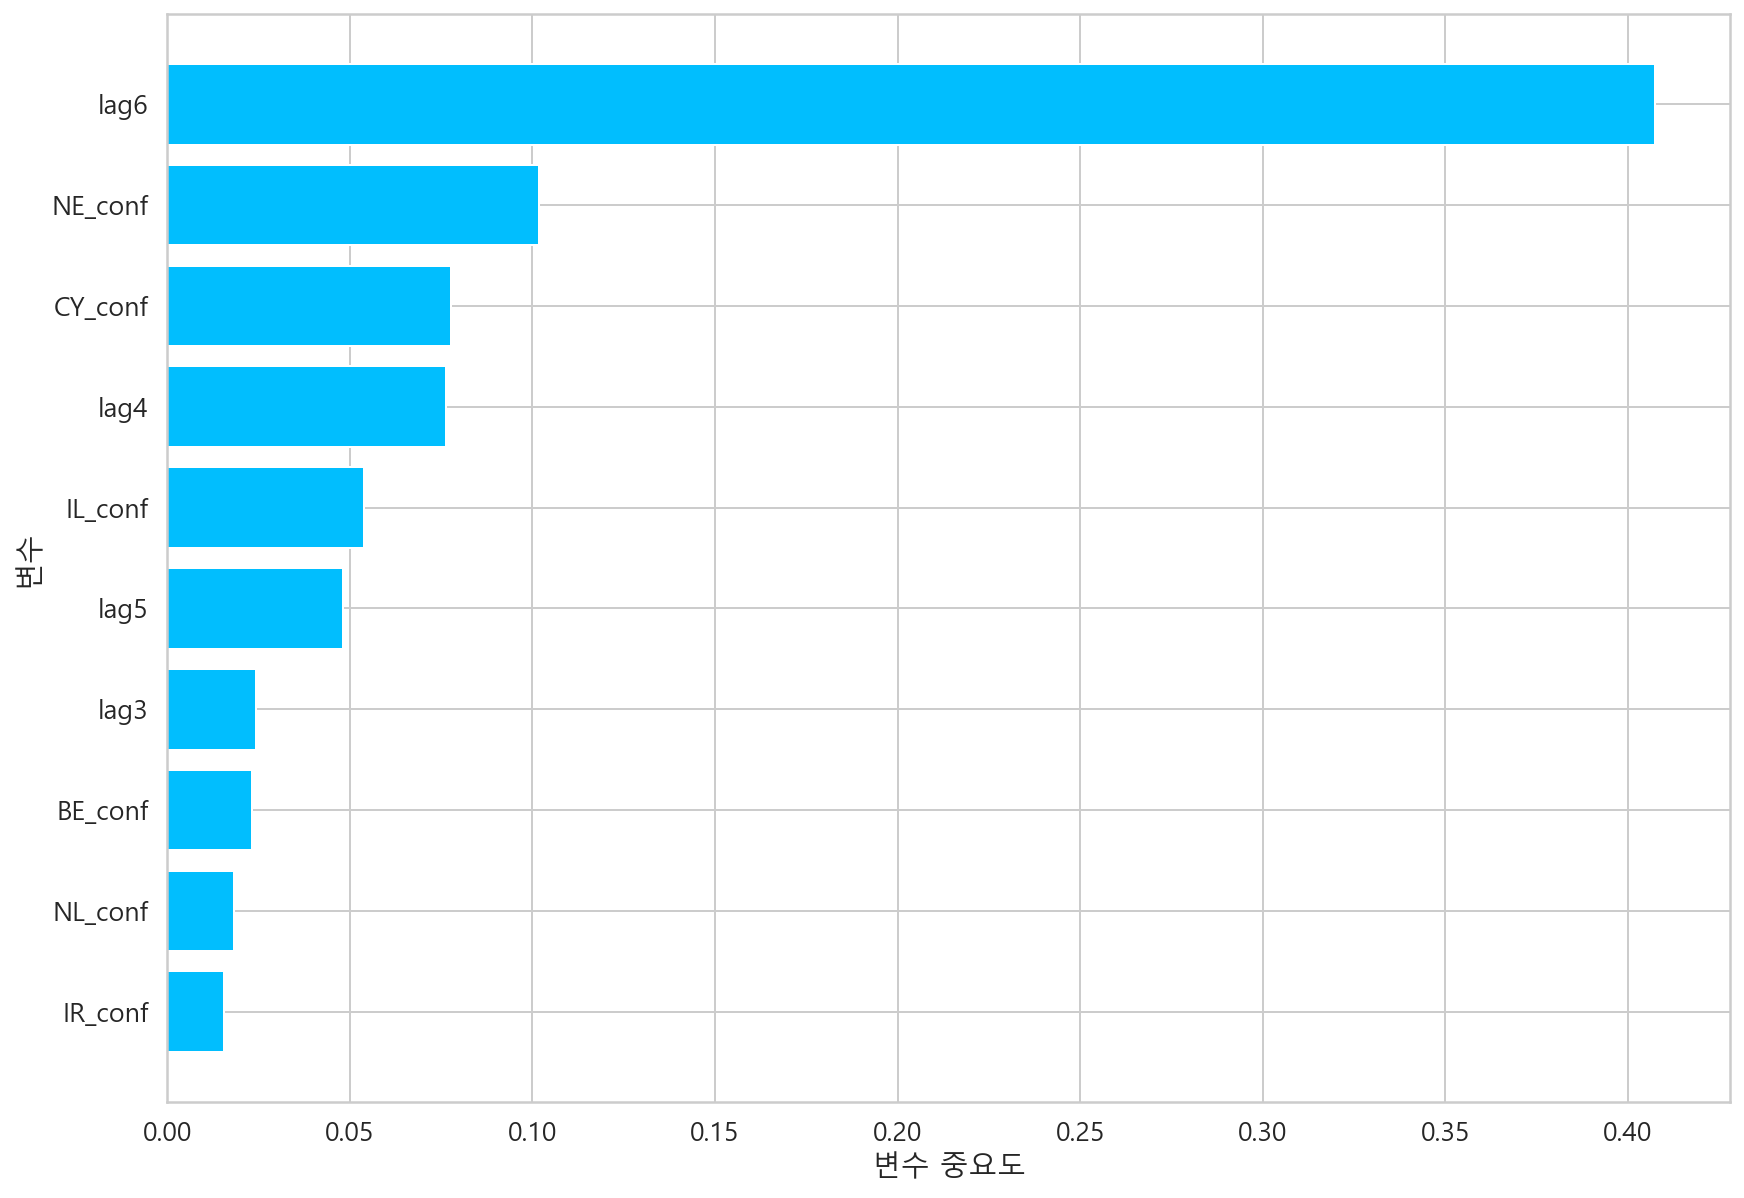

In [981]:
# 설명변수 중요도 그래
# 중요도가 높은 변수를 상위에 그림
# 상위 10개 확인
df_importance1 = df_importance.head(10)
df_importance1.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance1))
plt.barh(y = coordinates,
        width = df_importance1['Importance'])
plt.yticks(coordinates, df_importance1['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

In [982]:
col_names = list(df_importance1['Feature'])
col_names.append('target')

In [983]:
col_names

['IR_conf',
 'NL_conf',
 'BE_conf',
 'lag3',
 'lag5',
 'IL_conf',
 'lag4',
 'CY_conf',
 'NE_conf',
 'lag6',
 'target']

# 새로운 변수 넣고 LSTM 학습

In [985]:
df = df[col_names]

In [1009]:
# 테스트 데이터 수
test_data_size = 35

# X변수들과 y변수 구분
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [1010]:
round(len(df)*0.3)

29

In [1011]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

In [1012]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (63, 10)
test set :  (35, 10)


In [1013]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    
    for i in range(len(array)-seq_length-1):
        tmp = array[i:(i+seq_length)]
        res.append(tmp)
        
    return res

In [1014]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [1015]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [1016]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([61, 1, 10])
X_test : torch.Size([33, 1, 10])
y_train : torch.Size([61, 1])
y_test : torch.Size([33, 1])


# Building a Model

In [1017]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.5
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [1018]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [1019]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=32
n_layers=4
lr=1e-4
num_epochs=130

# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.04894144460558891 test loss: 0.07449981570243835
Epoch 10 train loss: 0.04845013469457626 test loss: 0.07520884275436401
Epoch 20 train loss: 0.047989290207624435 test loss: 0.07471903413534164
Epoch 30 train loss: 0.047503888607025146 test loss: 0.07350154966115952
Epoch 40 train loss: 0.046959392726421356 test loss: 0.07223459333181381
Epoch 50 train loss: 0.046312667429447174 test loss: 0.07095261663198471
Epoch 60 train loss: 0.045514803379774094 test loss: 0.06934777647256851
Epoch 70 train loss: 0.044506169855594635 test loss: 0.06728386878967285
Epoch 80 train loss: 0.043213069438934326 test loss: 0.0647321343421936
Epoch 90 train loss: 0.04154586419463158 test loss: 0.06161393225193024
Epoch 100 train loss: 0.03940485045313835 test loss: 0.057901956140995026
Epoch 110 train loss: 0.036699049174785614 test loss: 0.05381184443831444
Epoch 120 train loss: 0.03338012844324112 test loss: 0.04999677464365959


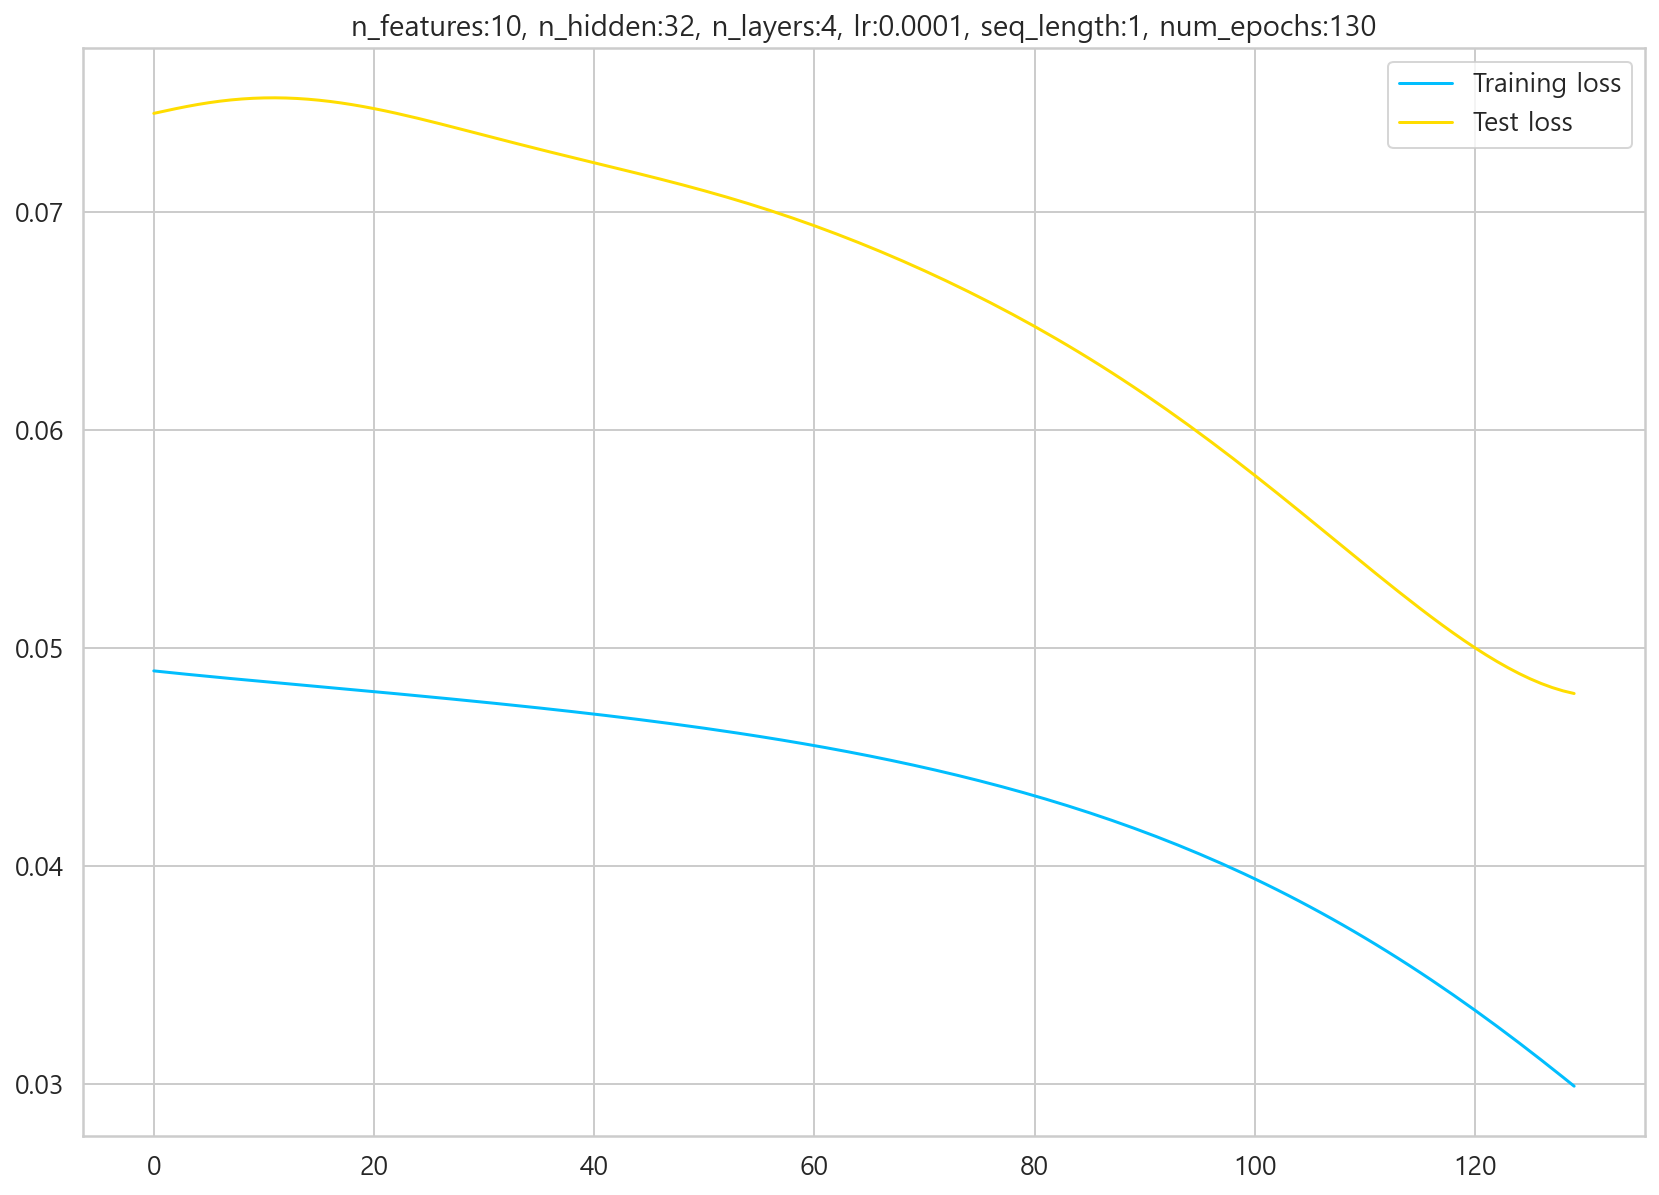

In [1020]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

In [942]:
# 모델 저장
PATH = './models/LSTM_seq1_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs)
torch.save(model, PATH)
# 모델 불러오기
model = torch.load(PATH)
#model.eval()

# Predicting daily cases

In [1021]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [1022]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [1023]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
pred_values_ceiled

[17,
 17,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17]

In [1024]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [1025]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [1026]:
# validation score
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [1027]:
score

59.74543041563612

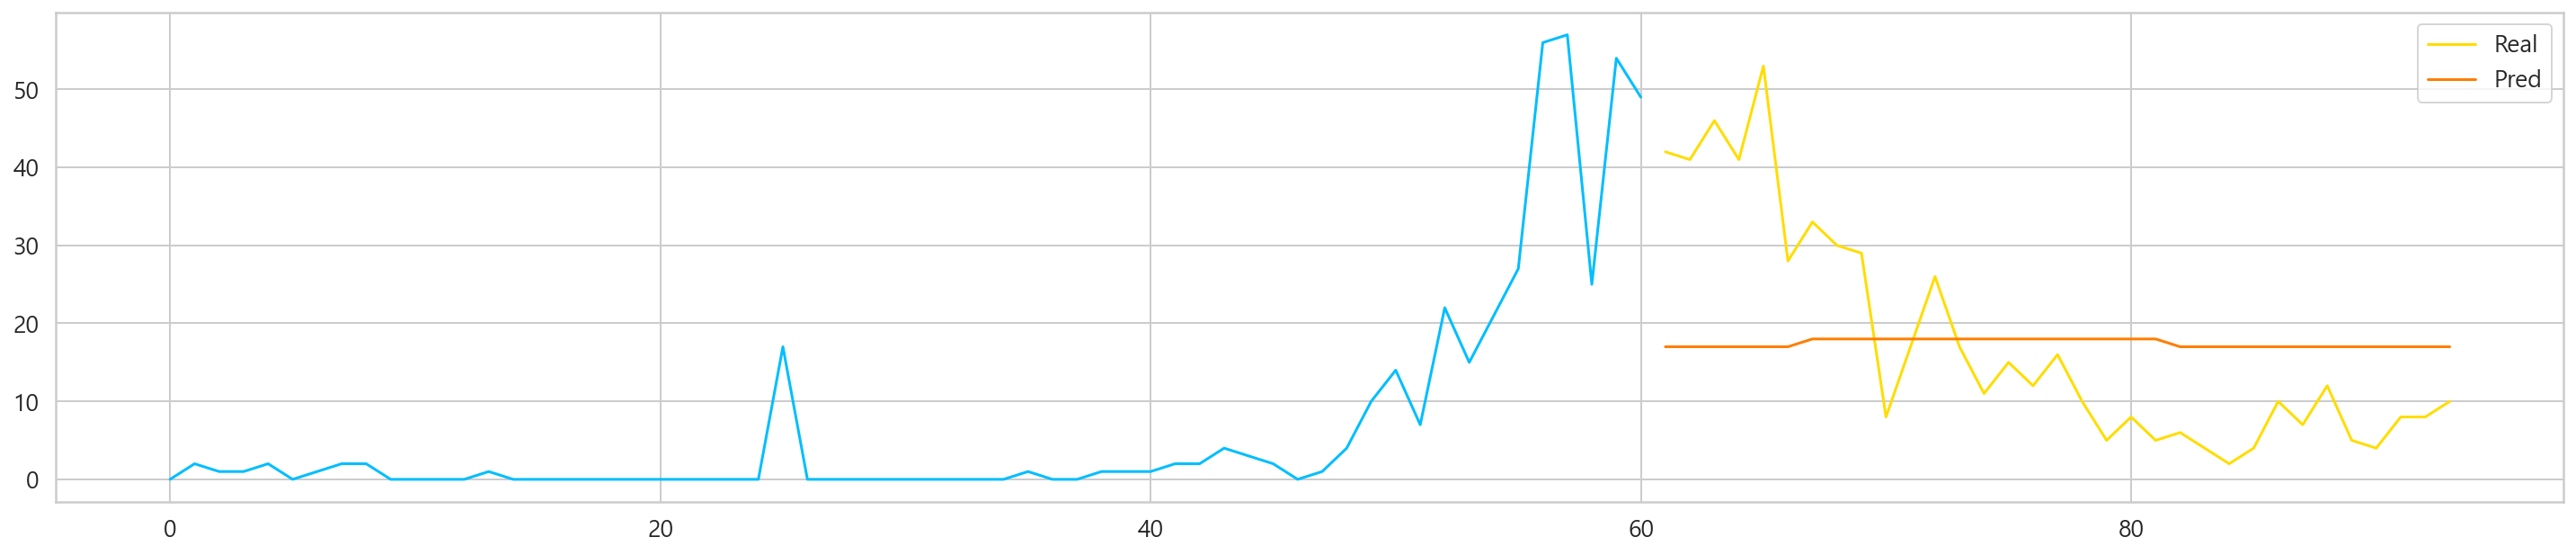

In [1028]:
plt.figure(figsize=(25,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(40)
plt.legend()

# Use all data for training

In [1029]:
# X변수들과 y변수 구분
X_all = df.iloc[:,:-1]
y_all = df.iloc[:,-1]

In [1030]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [1031]:
y_all

array([0.      , 0.03125 , 0.015625, 0.015625, 0.03125 , 0.      ,
       0.015625, 0.03125 , 0.03125 , 0.      , 0.      , 0.      ,
       0.      , 0.015625, 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.265625, 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.015625,
       0.      , 0.      , 0.015625, 0.015625, 0.015625, 0.03125 ,
       0.03125 , 0.0625  , 0.046875, 0.03125 , 0.      , 0.015625,
       0.0625  , 0.15625 , 0.21875 , 0.109375, 0.34375 , 0.234375,
       0.328125, 0.421875, 0.875   , 0.890625, 0.390625, 0.84375 ,
       0.765625, 1.      , 0.65625 , 0.65625 , 0.640625, 0.71875 ,
       0.640625, 0.828125, 0.4375  , 0.515625, 0.46875 , 0.453125,
       0.125   , 0.265625, 0.40625 , 0.265625, 0.171875, 0.234375,
       0.1875  , 0.25    , 0.15625 , 0.078125, 0.125   , 0.078125,
       0.09375 , 0.0625  , 0.03125 , 0.0625  , 0.15625 , 0.109

In [1032]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (98, 10)
y_all :  (98,)


In [1033]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    
    for i in range(len(array)-seq_length-1):
        tmp = array[i:(i+seq_length)]
        res.append(tmp)
        
    return res

In [1034]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [1035]:
model = CoronaVirusPredictor(
  n_features=n_features,
  n_hidden=n_hidden,
  seq_len=seq_length,
  n_layers=n_layers
)
model, train_hist, _ = train_model(model, X_all, y_all, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.07485947757959366
Epoch 10 train loss: 0.06970008462667465
Epoch 20 train loss: 0.0650554969906807
Epoch 30 train loss: 0.06087004393339157
Epoch 40 train loss: 0.0570736825466156
Epoch 50 train loss: 0.05359845981001854
Epoch 60 train loss: 0.05038144439458847
Epoch 70 train loss: 0.04735618829727173
Epoch 80 train loss: 0.04449290409684181
Epoch 90 train loss: 0.04185573384165764
Epoch 100 train loss: 0.039447445422410965
Epoch 110 train loss: 0.037192460149526596
Epoch 120 train loss: 0.03498639538884163


# Predicting future cases

In [1036]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [1037]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [1038]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
predicted_cases=pred_values_ceiled
predicted_cases

[15, 15, 15, 14, 13, 12, 10, 9, 9, 8, 7, 7, 6, 6]

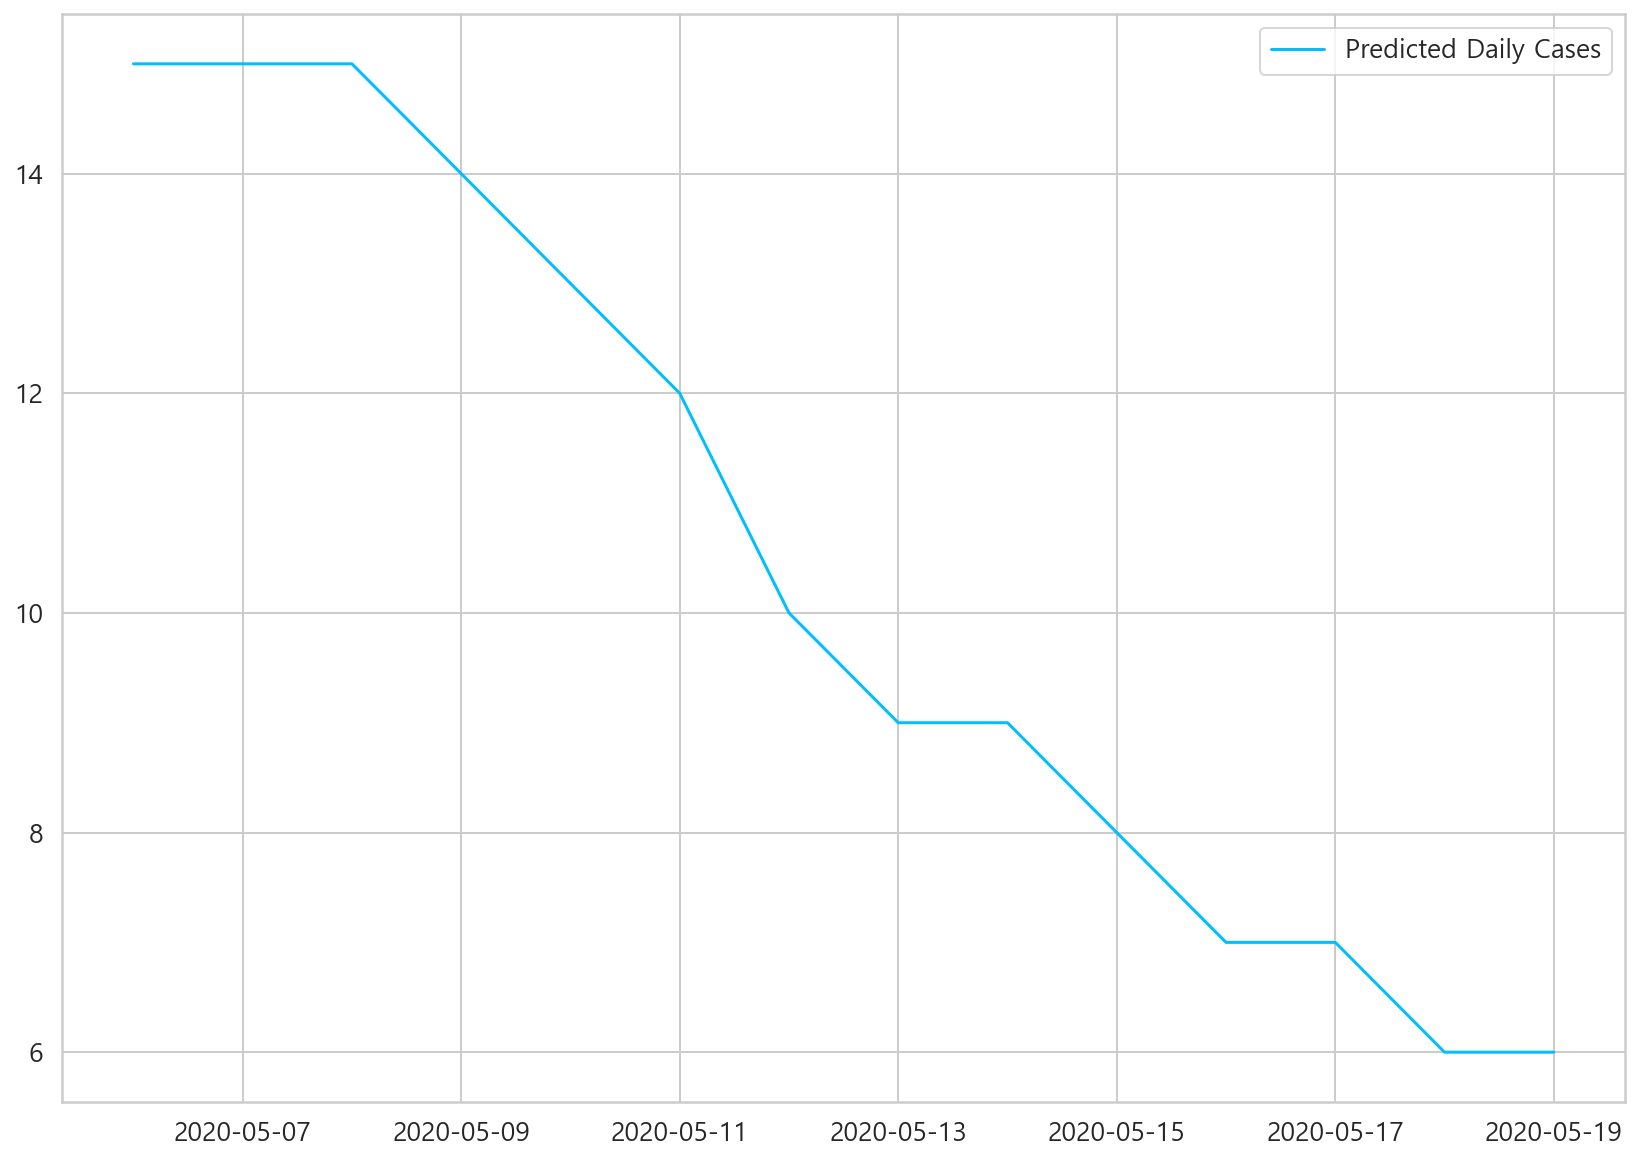

In [1039]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [1040]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [1041]:
preds_

,0
2020-05-06,15
2020-05-07,15
2020-05-08,15
2020-05-09,14
2020-05-10,13
2020-05-11,12
2020-05-12,10
2020-05-13,9
2020-05-14,9
2020-05-15,8


In [1042]:
df

,IR_conf,NL_conf,BE_conf,lag3,lag5,IL_conf,lag4,CY_conf,NE_conf,lag6,target
Date,,,,,,,,,,,
2020-01-29,0,0,0,1.0,1.0,0,0.0,0,0,0.0,0.0
2020-01-30,0,0,0,1.0,0.0,0,1.0,0,0,1.0,2.0
2020-01-31,0,0,0,0.0,1.0,0,1.0,0,0,0.0,1.0
2020-02-01,0,0,0,0.0,1.0,0,0.0,0,0,1.0,1.0
2020-02-02,0,0,0,2.0,0.0,0,0.0,0,0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,1006,476,513,12.0,10.0,155,7.0,7,9,4.0,8.0
2020-05-02,802,445,485,5.0,7.0,84,12.0,7,8,10.0,8.0
2020-05-03,976,335,389,4.0,12.0,23,5.0,8,14,7.0,10.0


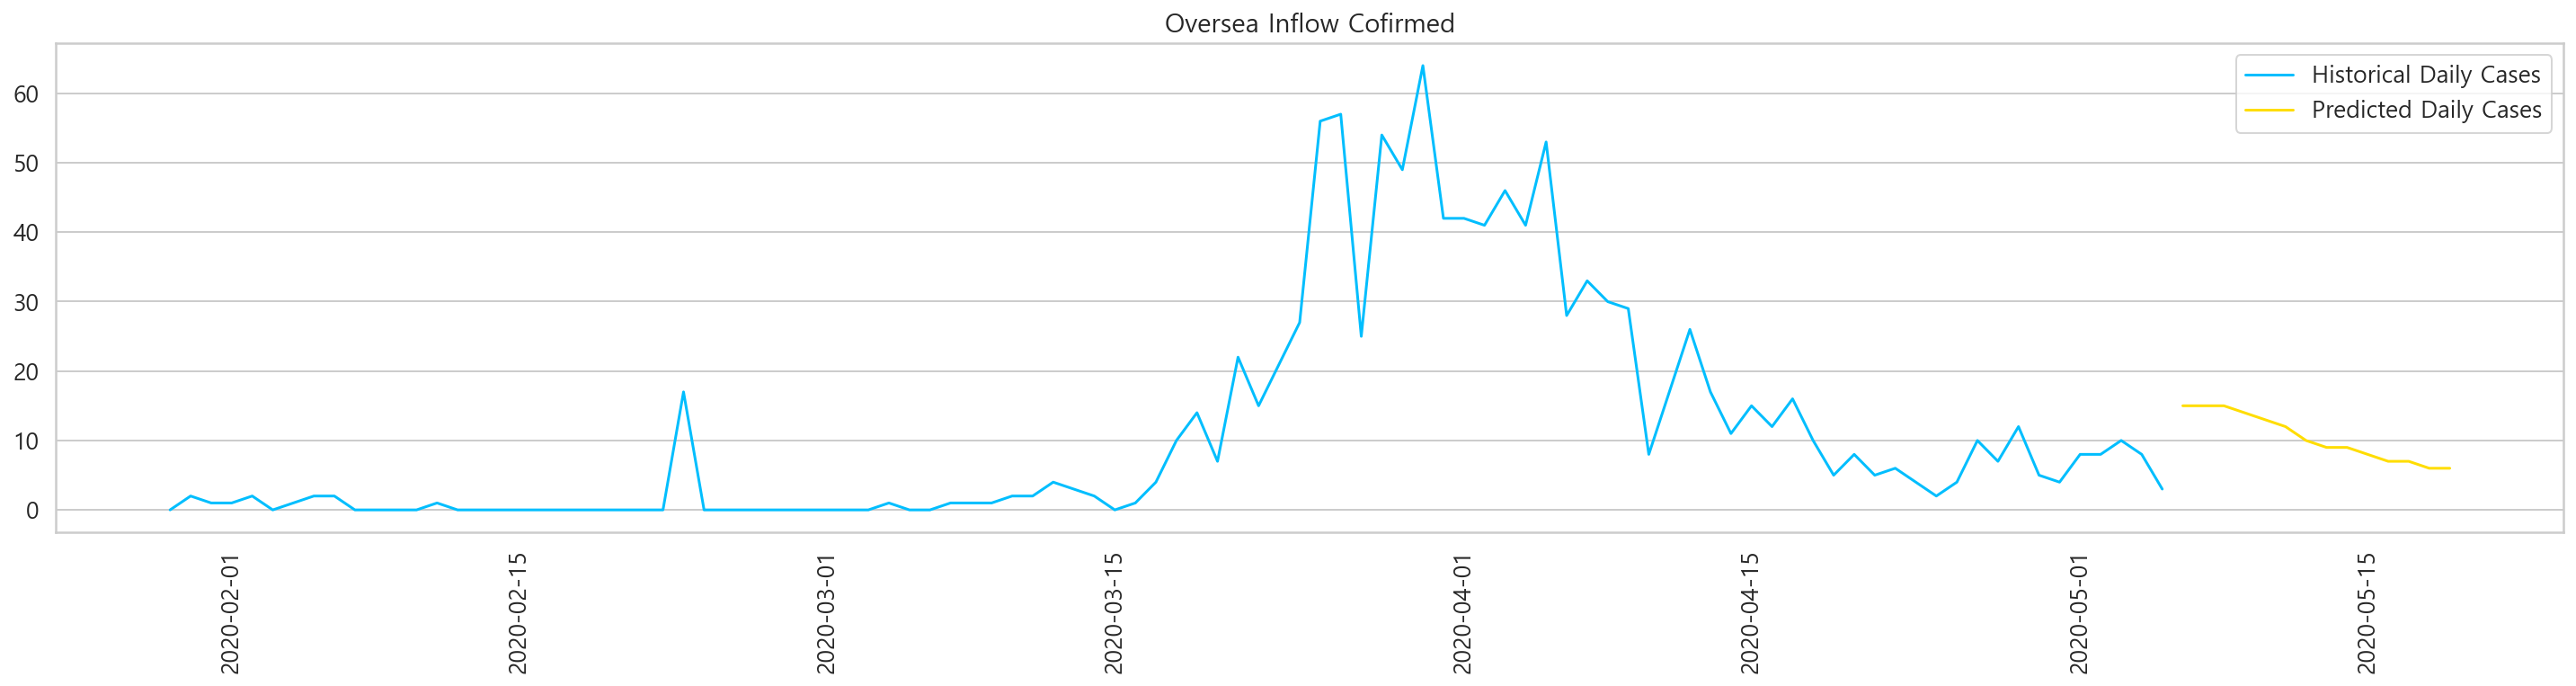

In [1043]:
plt.figure(figsize=(25,5))
plt.plot(df['target'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();